In [2]:
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

import matplotlib.pyplot as plt

import os
import datetime

### Read in Data

In [3]:
# Read in the bid-ask data from WRDS
bid_ask_df = pd.read_sas('../Data/bid_ask_data.sas7bdat')
print(bid_ask_df.shape)
bid_ask_df.head()

(957126, 8)


,PERMNO,DATE,BID,ASK,BIDLO,ASKHI,decile_category,stock_num
0,10028.0,2000-01-03,5.6250,6.12500,5.75000,6.3750,1.0,1.0
1,10514.0,2000-01-03,10.4375,10.56250,10.12500,10.5000,1.0,3.0
2,10656.0,2000-01-03,11.0000,11.25000,11.00000,11.0000,1.0,4.0
3,10661.0,2000-01-03,1.6250,1.65625,1.37500,1.8125,1.0,5.0
4,10838.0,2000-01-03,1.0000,1.06250,0.90625,1.0625,1.0,6.0


In [4]:
# Read in the CCI data
CCI_df = pd.read_csv('../Data/CCI.csv')
print(CCI_df.shape)
CCI_df.head()

(13203, 8)


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-01,99.75915,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-02,99.74998,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-03,99.88835,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-04,99.95676,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-05,100.01380,NaN


In [5]:
# Read in the ICS data
ICS_df = pd.read_csv('../Data/ICS.csv')
print(ICS_df.shape)
ICS_df.head()

(607, 3)


,Month,YYYY,ICS_ALL
0,November,1952,86.2
1,February,1953,90.7
2,August,1953,80.8
3,November,1953,80.7
4,February,1954,82.0


### Helper Functions

In [6]:
def bid_ask_estimate(...):
    # Question for Prof. Kramer: to compute beta (E[(ln(H_t/L_t)^2 + ln(H_t+1/L_t+1)^2)]) Yes!
    
    # beta = E{sum(j=0,1)[ln(H_(t+j)/L_(t+j))]^2} where H_(t) is the observed high price on day t (similarly for L)
    beta = ... # Just the average!
    
    # gamma = [ln(H_(t, t+1)/L_(t, t+1))]^2 where H_(t, t+1) is the high price over days t and t+1 (similarly for L)
    gamma = (np.log(high/low))**2
    
    # alpha = ((2beta)^0.5-beta^0.5)/(3-2*2^0.5) - (gamma/(3-2*2^0.5))^0.5
    alpha = (np.sqrt(2*beta)-np.sqrt(beta))/(3-2*np.sqrt(2))-np.sqrt(gamma/(3-2*np.sqrt(2)))
    
    # high-low spread estimate S = 2(e^alpha - 1)/(1+e^alpha)
    S = 2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    
    return S

In [7]:
def split_date_field(df, date_field):
    '''
    Extracts year and month columns from date column
    
    Return: df with month and year columns
    '''
    new_df = df.copy()
    
    split_date = new_df[date_field].str.split('-', n=1, expand=True)
    
    new_df['Year'] = split_date[0].astype(int)
    new_df['Month'] = split_date[1].astype(int)
    
    return new_df
    
def get_integer_month(df, month_field, short_names=False):
    '''
    Get months as integers from string month field
    
    Return: df with updated month field to have integer values
    '''
    
    new_df = df.copy()
    
    # Check for integer months
    if pd.api.types.is_integer_dtype(df[month_field]):
        print("Month field already in integer form.")
        return df
    
    # If not integer months, convert months to integers
    if short_names:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
    
    else:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%B").month)

    return new_df

In [8]:
def get_daily_data(df, trading_days, year_field, month_field, cols_to_keep=None):
    '''
    Interpolates the data on a daily basis from a monthly basis (same value between dates)
    
    Return: df with daily data
    '''
    
    trading_months = trading_days.month
    trading_years = trading_days.year
    date_df = pd.DataFrame({'Date': trading_days, 'Year': trading_years, 'Month': trading_months})
    
    if cols_to_keep:
        merged_df = date_df.merge(df[cols_to_keep+[year_field]+[month_field]], left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')
    
    else:
        merged_df = date_df.merge(df, left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')        
    
    return merged_df

### Pre-process the Data

In [23]:
# Extract month and year, then average the CCI data across each state
CCI_data_cleaned = split_date_field(CCI_df, 'TIME')
CCI_data_cleaned = CCI_data_cleaned.groupby(['TIME']).mean()[['Value', 'Year', 'Month']].reset_index()

# Get the integer monthly values for ICS data
ICS_data_cleaned = get_integer_month(ICS_df, 'Month')

# Get trading days
trading_days = pd.to_datetime(bid_ask_df.DATE.unique().astype(str))

# Get daily data for CCI and ICS
CCI_daily = get_daily_data(CCI_data_cleaned, trading_days, 'Year', 'Month')
ICS_daily = get_daily_data(ICS_data_cleaned, trading_days, 'YYYY', 'Month')

# Get rid of unnecessary columns, rename columns
CCI_daily = CCI_daily.drop(['Year', 'TIME'], axis=1)
CCI_daily = CCI_daily.rename({'Value': 'CCI'}, axis='columns')

ICS_daily = ICS_daily.drop(['Year', 'YYYY'], axis=1)
ICS_daily = ICS_daily.rename({'ICS_ALL': 'ICS'}, axis='columns')

In [33]:
# Convert date field to datetime
bid_ask_df['DATE'] = pd.to_datetime(bid_ask_df.DATE.astype(str))

# Get the absolute and relative bid-ask spread data
bid_ask_df['ABS_SPREAD'] = bid_ask_df.ASK - bid_ask_df.BID
bid_ask_df['REL_SPREAD'] = (bid_ask_df.ASK - bid_ask_df.BID)*2/(bid_ask_df.ASK + bid_ask_df.BID)

# Get the equal-weighted averages of firm-specific daily closing quoted spreads
bid_ask_daily = bid_ask_df.groupby(['DATE', 'decile_category']).mean().reset_index()
bid_ask_daily = bid_ask_daily.drop(['PERMNO', 'stock_num', 'BID', 'ASK', 'BIDLO', 'ASKHI'], axis='columns')
bid_ask_daily = bid_ask_daily.rename({'DATE': 'Date'}, axis='columns')
bid_ask_daily['Month'] = bid_ask_daily.Date.apply(lambda x: x.month)

In [43]:
# Combine datasets into one dataframe
all_data = bid_ask_daily.merge(CCI_daily, on=['Date', 'Month'], how='left')
all_data = all_data.merge(ICS_daily, on=['Date', 'Month'], how='left')
all_data = all_data.set_index('Date')

# Get the indicator columns for winter, (Dec - Feb), spring (Mar - May), summer (Jun - Aug)
all_data["Q1"] = all_data.Month.apply(lambda x: int(x >= 12 or x <= 2))
all_data["Q2"] = all_data.Month.apply(lambda x: int(x >= 3 and x <= 5))
all_data["Q3"] = all_data.Month.apply(lambda x: int(x >= 6 and x <= 8))

# Remove month field
all_data = all_data.drop(['Month'], axis='columns')

In [44]:
all_data.head()

,decile_category,ABS_SPREAD,REL_SPREAD,CCI,ICS,Q1,Q2,Q3
Date,,,,,,,,
2000-01-03,1.0,0.196429,0.036965,101.094044,112.0,1,0,0
2000-01-03,2.0,0.354687,0.043477,101.094044,112.0,1,0,0
2000-01-03,3.0,0.281250,0.041424,101.094044,112.0,1,0,0
2000-01-03,4.0,0.425347,0.040982,101.094044,112.0,1,0,0
2000-01-03,5.0,0.465278,0.037899,101.094044,112.0,1,0,0


### Visualize Data

<Figure size 432x288 with 0 Axes>

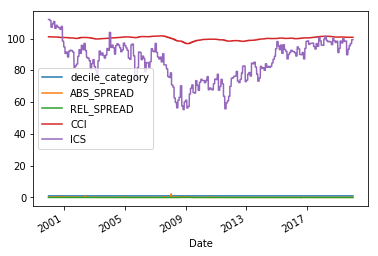

In [13]:
plt.figure()
all_data[all_data.decile_category==1].plot()

### Run Linear Regression

In [48]:
for i in range(10):
    decile_data = all_data[all_data.decile_category==i+1]

    X = sm.add_constant(decile_data[['CCI', 'ICS', 'Q1', 'Q2', 'Q3']])
    Y = decile_data['REL_SPREAD']

    model = sm.OLS(Y, X).fit()
    print("\nRegression Results for Decile", i+1)
    print(model.summary())


Regression Results for Decile 1
                            OLS Regression Results                            
Dep. Variable:             REL_SPREAD   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     180.5
Date:                Wed, 16 Dec 2020   Prob (F-statistic):          3.09e-177
Time:                        10:36:56   Log-Likelihood:                 14721.
No. Observations:                5031   AIC:                        -2.943e+04
Df Residuals:                    5025   BIC:                        -2.939e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.83

### Questions

1) Calculation of Corwin-Schultz Bid-Ask Spread Estimate - beta

2) Additional variables to include: Volume only? (aka Do we also need Turnover and Return Variance?) Volume from the previous day - Yes! De-trend over average dollar volume from prev. year.